In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from scipy.stats import norm
from scipy import stats

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix, classification_report,mean_absolute_error,r2_score, roc_auc_score
from time import time
from sklearn.model_selection import cross_val_score, train_test_split,cross_validate, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
# from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [20]:
np.random.seed(3)

## Load Data

In [2]:
dataURL = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
raw_data = pd.read_csv(dataURL)
print(raw_data.shape)
raw_data.columns

(7214, 53)


Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [3]:
compas_df = raw_data.loc[
    (raw_data['days_b_screening_arrest'] <= 30) &
    (raw_data['days_b_screening_arrest'] >= -30) &
    (raw_data['is_recid'] != -1) &
    (raw_data['c_charge_degree'] != "O") &
    (raw_data['score_text'] != "N/A")
]
len(compas_df)

6172

## Recidivism Classification

### Prepare Data

In [4]:
df = compas_df.copy()

#### Check missing data**

In [5]:
df[['sex','age','race','priors_count','c_charge_degree','two_year_recid']].isna().sum()

sex                0
age                0
race               0
priors_count       0
c_charge_degree    0
two_year_recid     0
dtype: int64

#### Check data bias. 
we can clearly see that the sample is unbalanced: Asian and Native Amerian samples are too small -> inapprociate to analyze and make predictions for them -> we'll add them to the Other group. This also makes the sample data more balanced.

In [6]:
df.loc[df['race'].isin(['Native American', 'Asian']), 'race'] = "Other"
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                385
Name: race, dtype: int64

#### Check data distribution

<AxesSubplot:>

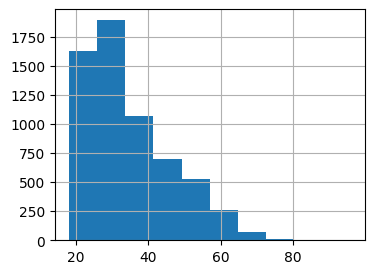

In [35]:
df['age'].hist(figsize = (4,3))

<AxesSubplot:>

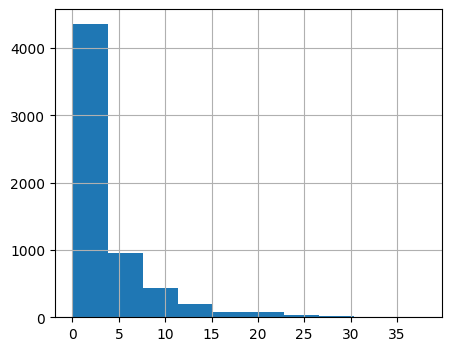

In [36]:
df['priors_counts'].hist(figsize = (5,4))

#### Check data balance

<AxesSubplot:>

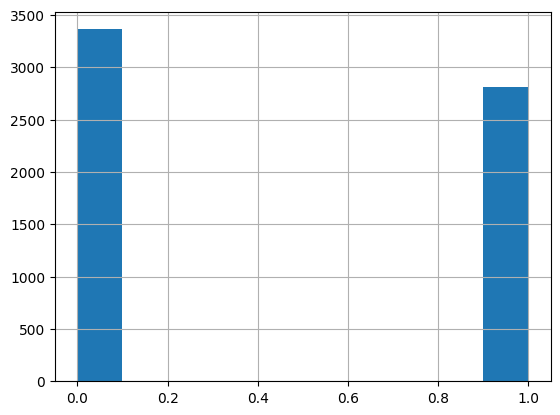

In [20]:
df['two_year_recid'].hist()

In [21]:
df['two_year_recid'].value_counts(normalize=True)

0    0.54488
1    0.45512
Name: two_year_recid, dtype: float64

the overall non-recidivism rate within two year of our sample was 0.55, while the rate of recidivism is 0.45 -> class imbalance. 
-> use Randomly Unsampling to balance the sample

In [7]:
features = df[['sex','age','race','priors_count','c_charge_degree']]
target = df['two_year_recid']
stratify = df['two_year_recid']

In [8]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(
        features, 
        target, 
        stratify = stratify,
        test_size = 0.3
)

In [9]:
# Randomly undersampling train data
# b/c test data doesn't affect the model prediction, we dont need to sampling them 
u_smpl = RandomUnderSampler() 
X_train_smpl, y_train_smpl = u_smpl.fit_resample(X_train, y_train)

In [38]:
# y_train_smpl.value_counts().plot.bar()

In [ ]:
# corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')

### Data Preprocessing

In [39]:
# classify data type
categorical_features = ['race','sex','c_charge_degree']
numerical_features = ['age','priors_count']

In [40]:
# pipeline to transform data
categorical_transformer = Pipeline(steps = [('onehot', OneHotEncoder(drop = 'if_binary'))])
numerical_transformer = Pipeline(steps = [('scale', StandardScaler())])

In [41]:
preprocessor = ColumnTransformer(transformers = [
    ('cat_preprocess', categorical_transformer, categorical_features),
    ('num_preprocess', numerical_transformer, numerical_features)
])

### Define metrics and functions

**our main metric: F1. But ROC AUC, precision, and recall are also use for model evaluation**

In [42]:
def validate_model(classifiers, X_train, y_train):
    for c in classifiers:
        model = Pipeline(steps = [
            ('preprocessor', preprocessor),
            ('classifier', c)])
        
        # define scoring metrics
        scoring = ['f1','roc_auc','precision','recall','accuracy']
        
        # generate cross validation for with defined random state
        skf = StratifiedKFold(n_splits=5)
        
        # run cross validation
        scores = cross_validate(
            model, 
            X_train, 
            y_train, 
            scoring = scoring, 
            cv = skf)
        
        # print results
        print(c)
        print("\t AVG F1 Score: %0.5f" % scores['test_f1'].mean())
        print("\t AVG AUC Score: %0.5f" % scores['test_roc_auc'].mean())
        # print("\t AVG Accuracy Score: %0.5f" % scores['test_accuracy'].mean())
        print("\t AVG Precision Score: %0.5f" % scores['test_precision'].mean())
        print("\t AVG Recall Score: %0.5f" % scores['test_accuracy'].mean())
        print()

### Model Comparison

Baseline Model: Logistic Regression
<br/>
Proposed Models: Random Forest, Decision Tree

In [43]:
classifers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
]

In [44]:
validate_model(classifers, X_train_smpl, y_train_smpl)

LogisticRegression()
	 AVG F1 Score: 0.65634
	 AVG AUC Score: 0.72214
	 AVG Precision Score: 0.66356
	 AVG Recall Score: 0.65972

DecisionTreeClassifier()
	 AVG F1 Score: 0.58773
	 AVG AUC Score: 0.61774
	 AVG Precision Score: 0.61428
	 AVG Recall Score: 0.60478

RandomForestClassifier()
	 AVG F1 Score: 0.62264
	 AVG AUC Score: 0.66910
	 AVG Precision Score: 0.61723
	 AVG Recall Score: 0.61928



**Our tree models aren't better than baseline logistic regression model -> need to tuning**

|Model          | AVG Accuracy Score      | AVG F1 Score      |
| :------------ | :-----------: | :-----------: |
| **Baseline Logistic Regression**  | **nnn%**     | **nnn%**   |
| Random Forest | **nnn%**  |**nnn%** 

## Find the best paramaters for tree models

### Decision Tree

In [270]:
# # Randomized Parameter Tuning

# dt_pipeline = Pipeline(steps = [
#         ('preprocessor', preprocessor),
#         ('model', DecisionTreeClassifier(random_state = 42))
# ])

# rs_dt = RandomizedSearchCV(
#         estimator = dt_pipeline, 
#         param_distributions = dt_param_dis, 
#         n_iter =100, 
#         cv = 3, 
#         random_state = 42, 
#         scoring ='f1_micro')

In [ ]:
# rs_dt.fit(X_train,y_train)
# print('best stcore = ' + str(rs_dt.best_score_))
# print('best params = ' + str(rs_dt.best_params_))

In [49]:
#  GridSearch CV
# define the param for searching
dt_pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier())
])

# dt_param_dis = {
#     'model__criterion': ['gini'],
#     'model__splitter': ['best'],
#     'model__max_depth': [2,5,None],
#     'model__min_samples_split': [None],
#     'model__max_features': [None]
# }

dt_param_dis = {
    'model__criterion': ['gini','entropy'],
    'model__splitter': ['best','random'],
    'model__max_depth': [2,5,10,20,40,None],
    'model__min_samples_split': [2,5,10,15],
    'model__max_features': ['auto','sqrt','log2',None]}

In [50]:
# function to call the fit search
def fit_search(model):
    start = time()
    model.fit(X_train_smpl, y_train_smpl)
    print('best score = ' + str(model.best_score_))
    print('best params = ' + str(model.best_params_))
    searching_time = time() - start
    print("Searching time: %0.8f" % searching_time)

In [51]:
dt_gs = GridSearchCV(
        estimator = dt_pipeline, 
        param_grid = dt_param_dis, 
        cv = 5,
        scoring ='f1_micro')

In [52]:
fit_search(dt_gs)

best score = 0.6681067344345617
best params = {'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_split': 2, 'model__splitter': 'best'}
Searching time: 13.18716121


### Random Forests

In [55]:
# define params for tuning 
rf_pipeline = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier())
])

rf_param_dis = {
    'model__n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 20)],
    'model__max_features': ['auto', 'sqrt'],
    'model__max_depth': [int(x) for x in np.linspace(80, 200, num = 10)]+[None],
    'model__min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 20, num = 5)],
    'model__min_samples_leaf': [int(x) for x in np.linspace(start = 1, stop = 20, num = 2)],
    'model__bootstrap': [True, False]
}

In [56]:
# Randomized Search
rf_rs = RandomizedSearchCV(
    estimator = rf_pipeline, 
    param_distributions = rf_param_dis, 
    n_iter = 100, 
    cv = 5, 
    scoring ='f1_micro')

In [57]:
fit_search(rf_rs)

best score = 0.6775208460640627
best params = {'model__n_estimators': 194, 'model__min_samples_split': 15, 'model__min_samples_leaf': 20, 'model__max_features': 'sqrt', 'model__max_depth': 186, 'model__bootstrap': False}
Searching time: 144.70084310


best score = 0.6777782088712572
best params = {'model__n_estimators': 257, 'model__min_samples_split': 6, 'model__min_samples_leaf': 20, 'model__max_features': 'sqrt', 'model__max_depth': 120, 'model__bootstrap': True}
Searching time: 143.15167522

In [78]:
# rf_param_gs = {
#     'model__n_estimators': [int(x) for x in np.linspace(start = 250, stop = 350, num = 10)],
#     'model__max_features': ['auto', 'sqrt'],
#     'model__max_depth': [int(x) for x in np.linspace(60, 100, num = 10)]+[None],
#     'model__min_samples_split': [int(x) for x in np.linspace(start = 15, stop = 25, num = 5)],
#     'model__min_samples_leaf': [int(x) for x in np.linspace(start = 15, stop = 25, num = 5)],
#     'model__bootstrap': [True, False]
# }

In [81]:
# rf_gs = GridSearchCV(
#         estimator = rf_pipeline, 
#         param_grid = rf_param_gs, 
#         cv = 3,
#         scoring ='accuracy')

In [71]:
# fit_search(rf_gs)

#### Compare models against the Test Set

In [45]:
def fit_and_predict(classifiers):
    for c in classifiers:
        model = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('classifier', c)])

        model.fit(X_train_smpl, y_train_smpl)
        y_preds = model.predict(X_test)
       
        print(c)
        print("\t F1 Score: %0.5f" % f1_score(y_test, y_preds))
        print("\t ROC AU C%0.5f" % roc_auc_score(y_test, y_preds))
        print()
        print("\t Classification Report","\n", classification_report(y_test, y_preds))
        print()

In [53]:
tuned_classifers =[
    LogisticRegression(),
    
    DecisionTreeClassifier(
        criterion = 'gini', 
        max_depth = 5, 
        max_features = None,
        min_samples_split = 2, 
        splitter = 'best'
    ),
    RandomForestClassifier(
        n_estimators = 257,
        max_depth = 120,
        max_features = 'sqrt',
        bootstrap = True,
        min_samples_split = 6,
        min_samples_leaf = 20
    )
]


In [48]:
fit_and_predict(tunned_classifers)

LogisticRegression()
	 F1 Score: 0.64754
	 ROC AU C0.67339

	 Classification Report 
               precision    recall  f1-score   support

           0       0.71      0.69      0.70      1009
           1       0.64      0.66      0.65       843

    accuracy                           0.67      1852
   macro avg       0.67      0.67      0.67      1852
weighted avg       0.68      0.67      0.68      1852


DecisionTreeClassifier(max_depth=5, min_samples_split=10, splitter='random')
	 F1 Score: 0.62003
	 ROC AU C0.61952

	 Classification Report 
               precision    recall  f1-score   support

           0       0.68      0.55      0.61      1009
           1       0.56      0.69      0.62       843

    accuracy                           0.61      1852
   macro avg       0.62      0.62      0.61      1852
weighted avg       0.63      0.61      0.61      1852


RandomForestClassifier(max_depth=120, min_samples_leaf=20, min_samples_split=6,
                       n_estimators=

In [54]:
fit_and_predict(tunned_classifers)

LogisticRegression()
	 F1 Score: 0.64754
	 ROC AU C0.67339

	 Classification Report 
               precision    recall  f1-score   support

           0       0.71      0.69      0.70      1009
           1       0.64      0.66      0.65       843

    accuracy                           0.67      1852
   macro avg       0.67      0.67      0.67      1852
weighted avg       0.68      0.67      0.68      1852


DecisionTreeClassifier(max_depth=5, min_samples_split=10, splitter='random')
	 F1 Score: 0.63052
	 ROC AU C0.64522

	 Classification Report 
               precision    recall  f1-score   support

           0       0.69      0.62      0.65      1009
           1       0.60      0.67      0.63       843

    accuracy                           0.64      1852
   macro avg       0.64      0.65      0.64      1852
weighted avg       0.65      0.64      0.64      1852


RandomForestClassifier(max_depth=120, min_samples_leaf=20, min_samples_split=6,
                       n_estimators=

{'model__n_estimators': 194, 'model__min_samples_split': 15, 'model__min_samples_leaf': 20, 'model__max_features': 'sqrt', 'model__max_depth': 186, 'model__bootstrap': False}

In [58]:
tuned_classifers =[
    LogisticRegression(),
    
    DecisionTreeClassifier(
        criterion = 'gini', 
        max_depth = 5, 
        max_features = None,
        min_samples_split = 2, 
        splitter = 'best'
    ),
    RandomForestClassifier(
        n_estimators = 194,
        max_depth = 186,
        max_features = 'sqrt',
        bootstrap = False,
        min_samples_split = 15,
        min_samples_leaf = 20
    )
]


In [59]:
fit_and_predict(tunned_classifers)

LogisticRegression()
	 F1 Score: 0.64754
	 ROC AU C0.67339

	 Classification Report 
               precision    recall  f1-score   support

           0       0.71      0.69      0.70      1009
           1       0.64      0.66      0.65       843

    accuracy                           0.67      1852
   macro avg       0.67      0.67      0.67      1852
weighted avg       0.68      0.67      0.68      1852


DecisionTreeClassifier(max_depth=5, min_samples_split=10, splitter='random')
	 F1 Score: 0.60592
	 ROC AU C0.62674

	 Classification Report 
               precision    recall  f1-score   support

           0       0.67      0.62      0.64      1009
           1       0.58      0.63      0.61       843

    accuracy                           0.63      1852
   macro avg       0.63      0.63      0.63      1852
weighted avg       0.63      0.63      0.63      1852


RandomForestClassifier(max_depth=120, min_samples_leaf=20, min_samples_split=6,
                       n_estimators=